<a href="https://colab.research.google.com/github/atitawat-pol/BADS7210-SNA/blob/master/Me.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Install 
!pip install dgl
!pip install dgl-cu100

     |████████████████████████████████| 3.5MB 13.1MB/s 


In [3]:
#import
%matplotlib inline

In [4]:
import torch
torch.cuda.is_available()

True

In [5]:
#GAT algorithm
from dgl.nn.pytorch import GATConv
import torch
import torch.nn as nn
import torch.nn.functional as F


class GATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim):
        super(GATLayer, self).__init__()
        self.g = g
        # equation (1)
        self.fc = nn.Linear(in_dim, out_dim, bias=False)
        # equation (2)
        self.attn_fc = nn.Linear(2 * out_dim, 1, bias=False)
        self.reset_parameters()

    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.fc.weight, gain=gain)
        nn.init.xavier_normal_(self.attn_fc.weight, gain=gain)

    def edge_attention(self, edges):
        # edge UDF for equation (2)
        z2 = torch.cat([edges.src['z'], edges.dst['z']], dim=1)
        a = self.attn_fc(z2)
        return {'e': F.leaky_relu(a)}

    def message_func(self, edges):
        # message UDF for equation (3) & (4)
        return {'z': edges.src['z'], 'e': edges.data['e']}

    def reduce_func(self, nodes):
        # reduce UDF for equation (3) & (4)
        # equation (3)
        alpha = F.softmax(nodes.mailbox['e'], dim=1)
        # equation (4)
        h = torch.sum(alpha * nodes.mailbox['z'], dim=1)
        return {'h': h}

    def forward(self, h):
        # equation (1)
        z = self.fc(h)
        self.g.ndata['z'] = z
        # equation (2)
        self.g.apply_edges(self.edge_attention)
        # equation (3) & (4)
        self.g.update_all(self.message_func, self.reduce_func)
        return self.g.ndata.pop('h')

class MultiHeadGATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim, num_heads, merge='cat'):
        super(MultiHeadGATLayer, self).__init__()
        self.heads = nn.ModuleList()
        for i in range(num_heads):
            self.heads.append(GATLayer(g, in_dim, out_dim))
        self.merge = merge

    def forward(self, h):
        head_outs = [attn_head(h) for attn_head in self.heads]
        if self.merge == 'cat':
            # concat on the output feature dimension (dim=1)
            return torch.cat(head_outs, dim=1)
        else:
            # merge using average
            return torch.mean(torch.stack(head_outs))
            
class GAT(nn.Module):
    def __init__(self, g, in_dim, hidden_dim, out_dim, num_heads):
        super(GAT, self).__init__()
        self.layer1 = MultiHeadGATLayer(g, in_dim, hidden_dim, num_heads)
        # Be aware that the input dimension is hidden_dim*num_heads since
        # multiple head outputs are concatenated together. Also, only
        # one attention head in the output layer.
        self.layer2 = MultiHeadGATLayer(g, hidden_dim * num_heads, out_dim, 1)

    def forward(self, h):
        h = self.layer1(h)
        h = F.elu(h)
        h = self.layer2(h)
        return h

DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [9]:
from google.colab import files
uploaded = files.upload()

Saving Class_user_status_class.csv to Class_user_status_class (2).csv


In [11]:
import io
import pandas as pd
df = pd.read_csv(io.BytesIO(uploaded['Class_user_status_class.csv']), dtype={'ID': str})
# Dataset is now stored in a Pandas Dataframe

In [12]:
df

,Screen_name,ID,Follower,Following,Food status,Non food status,Rate,is_food_inf
0,YouTube,10228272,72278755,1153,0,300,0.0,N
1,fm91trafficpro,148271173,2654960,70,0,300,0.0,N
2,BBCEarth,70725281,625728,902,0,300,0.0,N
3,ohmthitiwat,1351956895,333653,80,0,300,0.0,N
4,FlukeNatouch,490002009,324819,149,0,300,0.0,N
...,...,...,...,...,...,...,...,...
1516,nongkeki,1.25E+18,1,0,1,0,100.0,NaN
1517,praewachitsupha,1.14E+18,0,0,6,0,100.0,NaN
1518,lsuriyustyle,1.31E+18,0,0,4,0,100.0,NaN
1519,Orangino3,1.32E+18,0,1,2,0,100.0,NaN


In [ ]:
##import data

# 1. graph node(u>v) + weight of edges
from dgl import DGLGraph
edges = torch.tensor([0, 1, 2, 3, 4, 5]), torch.tensor([1, 2, 3, 4, 5, 0])
weights = torch.tensor([0.1, 0.6, 0.9, 0.7, 0.3, 0.5])  # weight of each edge
_g = DGLGraph(edges)
_g.edata['w'] = weights  # give it a name 'w'

# 2. Features of node
_features = torch.Tensor([[0,0.5,0.5,0.7,1,0,1,0.2,0.9,0.4],[1,0.5,0.5,0.2,1,1,0.2,0.5,1,0.8],[0.5,0.3,0.8,0.1,0,1,0.4,0.7,0.6,0.2],
          [0.8,0.2,0.1,1,1,0.7,0.1,0.1,0.1,0.6],[0,1,0.2,0.2,1,1,0.5,0.9,0.1,0.4],[0,1,0.5,0.1,0,1,0.9,0.2,0.4,0.5]])

# 3. label (1=Food, 0=Not Food)
_labels = torch.LongTensor([0,1,1,0,1,0])

# 4. mask (True=Train, False=Test)
_mask = torch.BoolTensor([False,True,False,False,True,True])

/usr/local/lib/python3.6/dist-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


In [ ]:
print(_g)
print(_features)
print(_labels)
print(_mask)
print(type(_g))
print(type(_features))
print(type(_labels))
print(type(_mask))

Graph(num_nodes=6, num_edges=6,
      ndata_schemes={}
      edata_schemes={'w': Scheme(shape=(), dtype=torch.float32)})
tensor([[0.0000, 0.5000, 0.5000, 0.7000, 1.0000, 0.0000, 1.0000, 0.2000, 0.9000,
         0.4000],
        [1.0000, 0.5000, 0.5000, 0.2000, 1.0000, 1.0000, 0.2000, 0.5000, 1.0000,
         0.8000],
        [0.5000, 0.3000, 0.8000, 0.1000, 0.0000, 1.0000, 0.4000, 0.7000, 0.6000,
         0.2000],
        [0.8000, 0.2000, 0.1000, 1.0000, 1.0000, 0.7000, 0.1000, 0.1000, 0.1000,
         0.6000],
        [0.0000, 1.0000, 0.2000, 0.2000, 1.0000, 1.0000, 0.5000, 0.9000, 0.1000,
         0.4000],
        [0.0000, 1.0000, 0.5000, 0.1000, 0.0000, 1.0000, 0.9000, 0.2000, 0.4000,
         0.5000]])
tensor([0, 1, 1, 0, 1, 0])
tensor([False,  True, False, False,  True,  True])
<class 'dgl.heterograph.DGLHeteroGraph'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [ ]:
#Training
import time
import numpy as np

# create the model, 2 heads, each head has hidden size 8
net = GAT(_g,
          in_dim=_features.size()[1],
          hidden_dim=8,
          out_dim=7,
          num_heads=2)

# Use GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# net = net.to(device)
_g = _g.to(device)

# create optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

# main loop
dur = []
losses = []
for epoch in range(30):
    if epoch >= 3:
        t0 = time.time()

    logits = net(_features)
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[_mask], _labels[_mask])

    losses.append(loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch >= 3:
        dur.append(time.time() - t0)

    print("Epoch {:05d} | Loss {:.4f} | Time(s) {:.4f}".format(
        epoch, loss.item(), np.mean(dur)))

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 00000 | Loss 2.9393 | Time(s) nan
Epoch 00001 | Loss 2.9072 | Time(s) nan
Epoch 00002 | Loss 2.8753 | Time(s) nan
Epoch 00003 | Loss 2.8435 | Time(s) 0.0075
Epoch 00004 | Loss 2.8118 | Time(s) 0.0076
Epoch 00005 | Loss 2.7803 | Time(s) 0.0075
Epoch 00006 | Loss 2.7489 | Time(s) 0.0075
Epoch 00007 | Loss 2.7177 | Time(s) 0.0075
Epoch 00008 | Loss 2.6866 | Time(s) 0.0075
Epoch 00009 | Loss 2.6558 | Time(s) 0.0075
Epoch 00010 | Loss 2.6250 | Time(s) 0.0075
Epoch 00011 | Loss 2.5945 | Time(s) 0.0074
Epoch 00012 | Loss 2.5641 | Time(s) 0.0074
Epoch 00013 | Loss 2.5339 | Time(s) 0.0074
Epoch 00014 | Loss 2.5039 | Time(s) 0.0074
Epoch 00015 | Loss 2.4741 | Time(s) 0.0074
Epoch 00016 | Loss 2.4444 | Time(s) 0.0076
Epoch 00017 | Loss 2.4150 | Time(s) 0.0076
Epoch 00018 | Loss 2.3857 | Time(s) 0.0076
Epoch 00019 | Loss 2.3566 | Time(s) 0.0076
Epoch 00020 | Loss 2.3277 | Time(s) 0.0076
Epoch 00021 | Loss 2.2990 | Time(s) 0.0076
Epoch 00022 | Loss 2.2706 | Time(s) 0.0076
Epoch 00023 | Loss 2

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


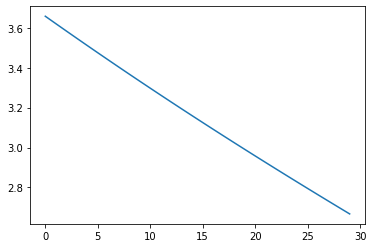

In [ ]:
#Visualize the training loss
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt = sns.lineplot(loss_indices, losses_float)
plt